# Step 0. Optionally unzip data (for google Colab)

In [1]:
# importing the zipfile module
from zipfile import ZipFile

# loading the temp.zip and creating a zip object
with ZipFile("processed-images.zip", 'r') as zObject:

    # Extracting all the members of the zip
    # into a specific location.
    zObject.extractall(
        path="")

# Step 1. Load and Proprocess data

In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load the CSV data
df = pd.read_csv('images.csv', header=None, names=["image_path", "label", "timestamp", "moon_phase", "wind", "weather", "temp", "humidity", "pressure"])

# Filter out rows where image paths do not exist
df = df[df['image_path'].apply(os.path.exists)]

# Convert timestamp to datetime with UTC conversion, with error handling
df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)

# Drop rows with invalid timestamps (NaT)
df.dropna(inplace=True)

# Extract features from the timestamp
df['hour'] = df['timestamp'].dt.hour  # Hour of the day
df['day_of_week'] = df['timestamp'].dt.dayofweek  # Day of the week
df['is_night'] = (df['hour'] < 6) | (df['hour'] > 18)  # Simple binary night/day indicator

# Handle categorical features (moon_phase, weather) with one-hot encoding
df = pd.get_dummies(df, columns=['moon_phase', 'weather'], drop_first=True)

# Scale numerical features
scaler = StandardScaler()
df[['wind', 'temp', 'humidity', 'pressure']] = scaler.fit_transform(df[['wind', 'temp', 'humidity', 'pressure']])

<ipython-input-2-988f6df26b92>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)
<ipython-input-2-988f6df26b92>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)
<ipython-input-2-988f6df26b92>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Step 2. Load Images

In [3]:
from concurrent.futures import ThreadPoolExecutor
from tensorflow.keras.preprocessing import image

# Function to load and normalize images
def load_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize pixel values to [0, 1]
    return img_array.astype(np.float32)

# Load all images in parallel using ThreadPoolExecutor
def load_images_in_parallel(image_paths, batch_size=32, target_size=(224, 224)):
    images = []
    with ThreadPoolExecutor() as executor:
        for i in range(0, len(image_paths), batch_size):
            batch_paths = image_paths[i:i + batch_size]
            batch_images = list(executor.map(lambda path: load_image(path, target_size), batch_paths))
            images.extend(batch_images)
    return np.array(images)

# Load images and convert to NumPy array
images = load_images_in_parallel(df['image_path'].values)


# Step 3. Prepare Metadata and Labels

In [4]:
from sklearn.model_selection import train_test_split

# Extract metadata features as NumPy array
metadata_columns = ['hour', 'day_of_week', 'is_night', 'wind', 'temp', 'humidity', 'pressure'] + \
                   [col for col in df.columns if col.startswith('moon_phase_') or col.startswith('weather_')]
metadata = df[metadata_columns].values.astype(np.float32)

# Convert labels to binary format (0: not deer, 1: deer)
labels = (df['label'] == 'deer').astype(int).values

# Split the data into training and validation sets
X_train_images, X_val_images, X_train_metadata, X_val_metadata, y_train, y_val = train_test_split(
    images, metadata, labels, test_size=0.2, random_state=42
)


# Step 4. Build and Train Metadata-Only Model

In [26]:
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping

# Define the metadata-only model
metadata_input = layers.Input(shape=(metadata.shape[1],))
x = layers.Dense(128, activation='relu')(metadata_input)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1, activation='sigmoid')(x)
metadata_model = models.Model(inputs=metadata_input, outputs=x)

# Compile the model with a learning rate scheduler
initial_lr = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_lr, decay_steps=10000, decay_rate=0.9, staircase=True
)

optimizer = optimizers.Adam(learning_rate=lr_schedule)
metadata_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
metadata_history = metadata_model.fit(
    X_train_metadata,
    y_train,
    validation_data=(X_val_metadata, y_val),
    epochs=50,
    batch_size=16,
    callbacks=[early_stopping]
)


Epoch 1/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5892 - loss: 0.8936 - val_accuracy: 0.6291 - val_loss: 0.6200
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6384 - loss: 0.7337 - val_accuracy: 0.7207 - val_loss: 0.5976
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6846 - loss: 0.6350 - val_accuracy: 0.7230 - val_loss: 0.5976
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6820 - loss: 0.6234 - val_accuracy: 0.6408 - val_loss: 0.6134
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7161 - loss: 0.5985 - val_accuracy: 0.7207 - val_loss: 0.5856
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7180 - loss: 0.6022 - val_accuracy: 0.7136 - val_loss: 0.5790
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7466 - loss: 0.5696 - val_accuracy: 0.7160 - val_loss: 0.5819
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7417 - loss: 0.5572 - val_accuracy: 0

# Step 5. Build and Train Image Only Model

In [27]:
# Define the image-only model
image_input = layers.Input(shape=(224, 224, 3))
x = layers.Conv2D(32, (3, 3), activation='relu')(image_input)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1, activation='sigmoid')(x)
image_model = models.Model(inputs=image_input, outputs=x)

# Compile the model with a learning rate scheduler
initial_lr = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_lr, decay_steps=10000, decay_rate=0.9, staircase=True
)

optimizer = optimizers.Adam(learning_rate=lr_schedule)
image_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
image_history = image_model.fit(
    X_train_images,
    y_train,
    validation_data=(X_val_images, y_val),
    epochs=50,
    batch_size=16,
    callbacks=[early_stopping]
)


Epoch 1/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.6798 - loss: 0.7721 - val_accuracy: 0.6690 - val_loss: 0.5849
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.7053 - loss: 0.5711 - val_accuracy: 0.7066 - val_loss: 0.5511
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.7633 - loss: 0.5395 - val_accuracy: 0.7394 - val_loss: 0.5243
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.7723 - loss: 0.5080 - val_accuracy: 0.7465 - val_loss: 0.5128
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.7833 - loss: 0.4948 - val_accuracy: 0.7629 - val_loss: 0.5067
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.7696 - loss: 0.4943 - val_accuracy: 0.7582 - val_loss: 0.4846
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.8051 - loss: 0.4539 - val_accuracy: 0.7629 - val_loss: 0.4514
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.8027 - loss: 0.4507 - val_acc

# Step 6. Build and Train Combined Model

In [23]:
import tensorflow as tf

# Define the model with dropout and learning rate scheduler
image_input = layers.Input(shape=(224, 224, 3))  # Shape of the images (224x224 RGB images)

# Image model
x = layers.Conv2D(32, (3, 3), activation='relu')(image_input)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Flatten()(x)

# Combine image model and metadata
metadata_input = layers.Input(shape=(metadata.shape[1],))  # Shape of metadata (after one-hot encoding)
combined = layers.concatenate([x, metadata_input])

# Add a fully connected layer, dropout for regularization, and output layer
x = layers.Dense(128, activation='relu')(combined)
x = layers.Dropout(0.5)(x)  # Dropout to reduce overfitting
x = layers.Dense(1, activation='sigmoid')(x)  # Sigmoid for binary classification

# Define the model
combined_model = models.Model(inputs=[image_input, metadata_input], outputs=x)

# Compile the model with a learning rate scheduler
initial_lr = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_lr, decay_steps=10000, decay_rate=0.9, staircase=True
)

optimizer = optimizers.Adam(learning_rate=lr_schedule)
combined_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Metric to monitor (e.g., 'val_loss' or 'val_accuracy')
    patience=5,          # Number of epochs with no improvement to wait before stopping
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored metric
)

# Train the model
combined_history = combined_model.fit(
    [X_train_images, X_train_metadata],  # Input data (images and metadata)
    y_train,  # Labels
    validation_data=([X_val_images, X_val_metadata], y_val),  # Validation data
    epochs=50,
    batch_size=16,
    callbacks=[early_stopping],  # Include the EarlyStopping callback here
)

Epoch 1/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.6216 - loss: 0.7376 - val_accuracy: 0.6831 - val_loss: 0.6030
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.7158 - loss: 0.6006 - val_accuracy: 0.7465 - val_loss: 0.5625
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.7231 - loss: 0.5635 - val_accuracy: 0.7582 - val_loss: 0.5111
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.7812 - loss: 0.4970 - val_accuracy: 0.6455 - val_loss: 0.7237
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.7775 - loss: 0.5227 - val_accuracy: 0.7300 - val_loss: 0.5792
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.7354 - loss: 0.5462 - val_accuracy: 0.7700 - val_loss: 0.4969
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.8079 - loss: 0.4506 - val_accuracy: 0.8075 - val_loss: 0.4261
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8221 - loss: 0.4317 - val_accu

# Step 7. Augmented Model

In [29]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
])

# Define the model with dropout and learning rate scheduler
image_input = layers.Input(shape=(224, 224, 3))

# Augmentation applied to the input images
augmented_images = data_augmentation(image_input)

# Image model
x = layers.Conv2D(32, (3, 3), activation='relu')(augmented_images)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Flatten()(x)

# Metadata input and combination
metadata_input = layers.Input(shape=(metadata.shape[1],))
combined = layers.concatenate([x, metadata_input])

# Fully connected layers with dropout
x = layers.Dense(128, activation='relu')(combined)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation='sigmoid')(x)

# Define and compile the model
augmented_model = models.Model(inputs=[image_input, metadata_input], outputs=output)

# Compile with a learning rate scheduler
initial_lr = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_lr, decay_steps=10000, decay_rate=0.9, staircase=True
)

optimizer = optimizers.Adam(learning_rate=lr_schedule)
augmented_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Train the model
augmented_history = augmented_model.fit(
    [X_train_images, X_train_metadata],
    y_train,
    validation_data=([X_val_images, X_val_metadata], y_val),
    epochs=50,
    batch_size=16,
    callbacks=[early_stopping]
)


Epoch 1/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.6352 - loss: 1.0462 - val_accuracy: 0.6808 - val_loss: 0.6261
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.7171 - loss: 0.5731 - val_accuracy: 0.6291 - val_loss: 0.6183
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.6740 - loss: 0.5899 - val_accuracy: 0.6362 - val_loss: 0.6564
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.6888 - loss: 0.5965 - val_accuracy: 0.6408 - val_loss: 0.6065
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.7104 - loss: 0.5944 - val_accuracy: 0.4765 - val_loss: 0.7117
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.6988 - loss: 0.6079 - val_accuracy: 0.6925 - val_loss: 0.6184
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.7478 - loss: 0.5722 - val_accuracy: 0.6831 - val_loss: 0.5893
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.7449 - loss: 0.5469 - val_accu

# Step 8. Transfer Learning Model

In [30]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

# Pre-trained model for feature extraction
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

# Define the model
image_input = layers.Input(shape=(224, 224, 3))
x = preprocess_input(image_input)  # Preprocess input for ResNet50
x = base_model(x, training=False)  # Use the pre-trained model
x = layers.GlobalAveragePooling2D()(x)  # Pooling to reduce feature map dimensionality

# Metadata input and combination
metadata_input = layers.Input(shape=(metadata.shape[1],))
combined = layers.concatenate([x, metadata_input])

# Fully connected layers with dropout
x = layers.Dense(128, activation='relu')(combined)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation='sigmoid')(x)

# Define and compile the model
transfer_model = models.Model(inputs=[image_input, metadata_input], outputs=output)

# Compile with a learning rate scheduler
initial_lr = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_lr, decay_steps=10000, decay_rate=0.9, staircase=True
)

optimizer = optimizers.Adam(learning_rate=lr_schedule)
transfer_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Train the model
transfer_history = transfer_model.fit(
    [X_train_images, X_train_metadata],
    y_train,
    validation_data=([X_val_images, X_val_metadata], y_val),
    epochs=50,
    batch_size=16,
    callbacks=[early_stopping]
)


Epoch 1/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 25s 146ms/step - accuracy: 0.6096 - loss: 0.7322 - val_accuracy: 0.6268 - val_loss: 0.6164
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.6644 - loss: 0.6088 - val_accuracy: 0.6620 - val_loss: 0.6087
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.6680 - loss: 0.6143 - val_accuracy: 0.6268 - val_loss: 0.6027
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.6908 - loss: 0.5862 - val_accuracy: 0.7113 - val_loss: 0.6117
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.6858 - loss: 0.6089 - val_accuracy: 0.7113 - val_loss: 0.5911
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.7007 - loss: 0.5903 - val_accuracy: 0.6408 - val_loss: 0.5969
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.7044 - loss: 0.5770 - val_accuracy: 0.6385 - val_loss: 0.6088
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.7254 - loss: 0.5591 - val

# Step 9. Evaluate and Compare Models

In [33]:
# Import evaluation metrics
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import time

def evaluate_model(model, X_val, y_val, model_name):
    start_time = time.time()  # Start timing
    predictions = (model.predict(X_val) > 0.5).astype(int)  # Binary predictions
    elapsed_time = time.time() - start_time  # Time taken for prediction

    accuracy = accuracy_score(y_val, predictions)
    recall = recall_score(y_val, predictions)
    f1 = f1_score(y_val, predictions)
    auc = roc_auc_score(y_val, model.predict(X_val))

    print(f"{model_name} - Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, AUC: {auc:.4f}")
    print(f"{model_name} - Evaluation Time: {elapsed_time:.4f} seconds")

    return {
        "Model": model_name,
        "Accuracy": accuracy,
        "Recall": recall,
        "F1 Score": f1,
        "AUC": auc,
        "Evaluation Time (s)": elapsed_time
    }


# Evaluate each model and store results
evaluation_results = []

evaluation_results.append(evaluate_model(metadata_model, X_val_metadata, y_val, "Metadata-Only Model"))
evaluation_results.append(evaluate_model(image_model, X_val_images, y_val, "Image-Only Model"))
evaluation_results.append(evaluate_model(combined_model, [X_val_images, X_val_metadata], y_val, "Combined Model"))
evaluation_results.append(evaluate_model(augmented_model, [X_val_images, X_val_metadata], y_val, "Augmented Model"))
evaluation_results.append(evaluate_model(transfer_model, [X_val_images, X_val_metadata], y_val, "Transfer Model"))

# Convert evaluation results into a DataFrame for easier visualization
import pandas as pd
results_df = pd.DataFrame(evaluation_results)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Metadata-Only Model - Accuracy: 0.7230, Recall: 0.9513, F1 Score: 0.8115, AUC: 0.7180
Metadata-Only Model - Evaluation Time: 0.3475 seconds
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Image-Only Model - Accuracy: 0.9155, Recall: 0.9326, F1 Score: 0.9326, AUC: 0.9477
Image-Only Model - Evaluation Time: 2.0580 seconds
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Combined Model - Accuracy: 0.9061, Recall: 0.9326, F1 Score: 0.9257, AUC: 0.9463
Combined Model - Evaluation Time: 0.7982 seconds
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Augmented Model - Accuracy: 0.7512, Recall: 0.8989, F1 Score: 0.8191, AUC: 0.7944
Augmented Model - Evaluation Time: 0.8365 seconds
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
Transfer Model - Accuracy: 0.7324, Recall: 0.8689, F1 Score: 0.8

# Step 10. Graph

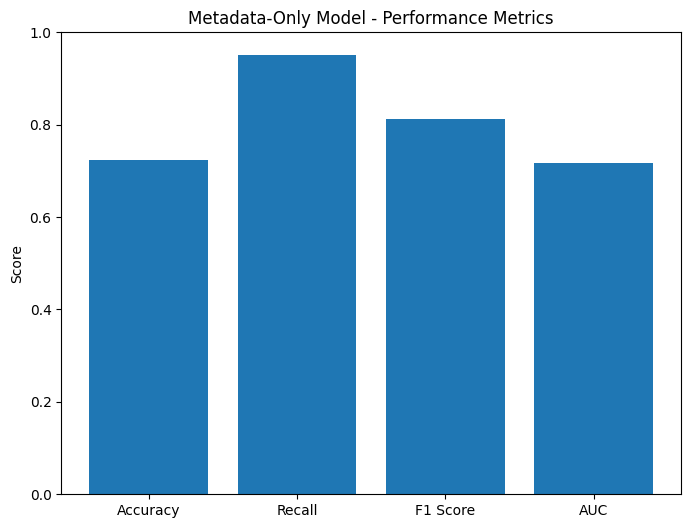

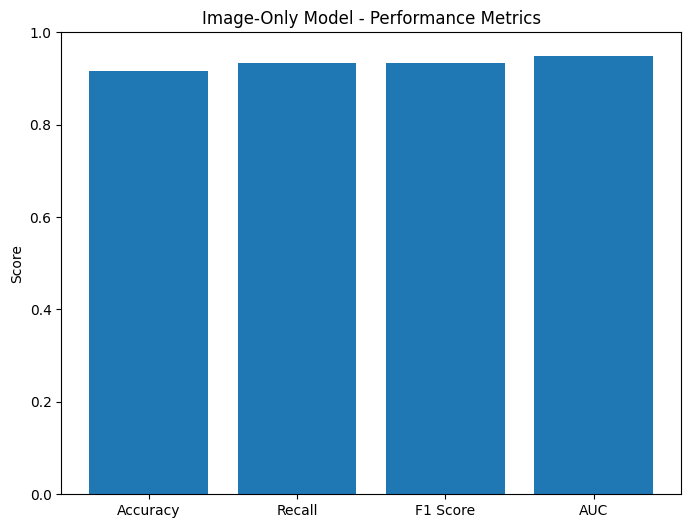

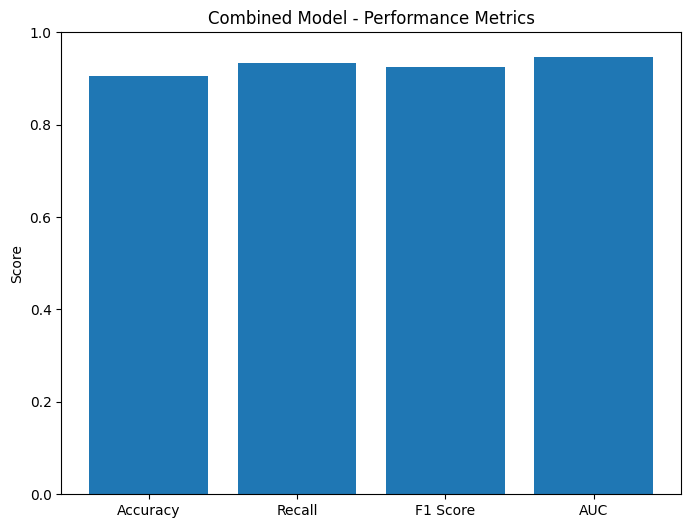

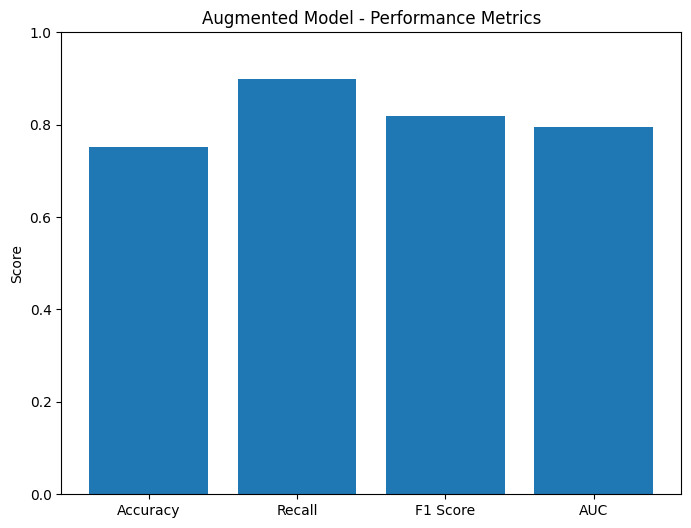

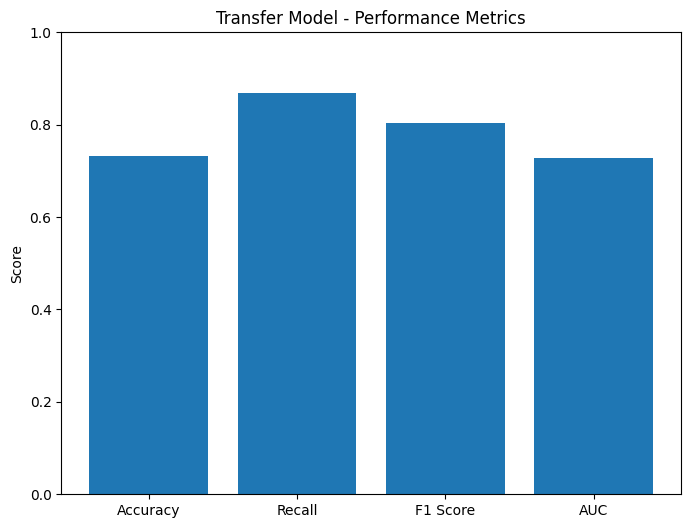

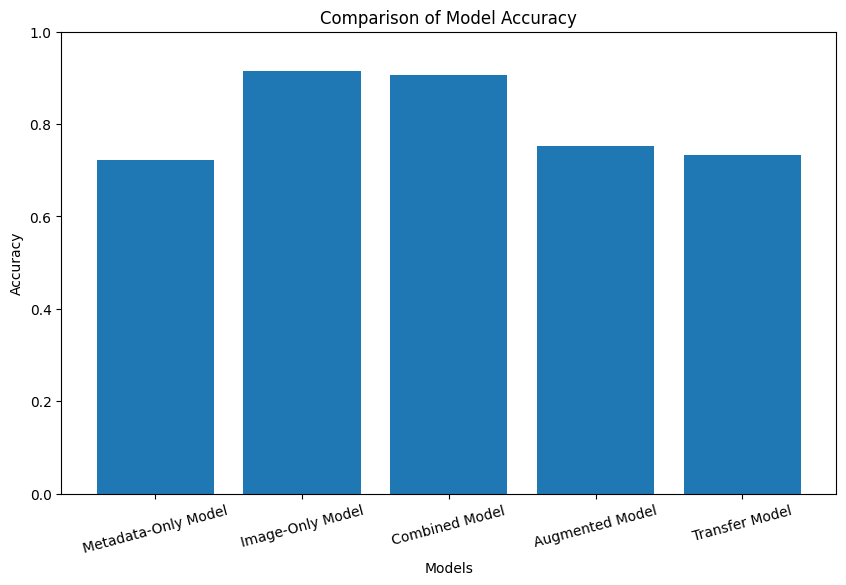

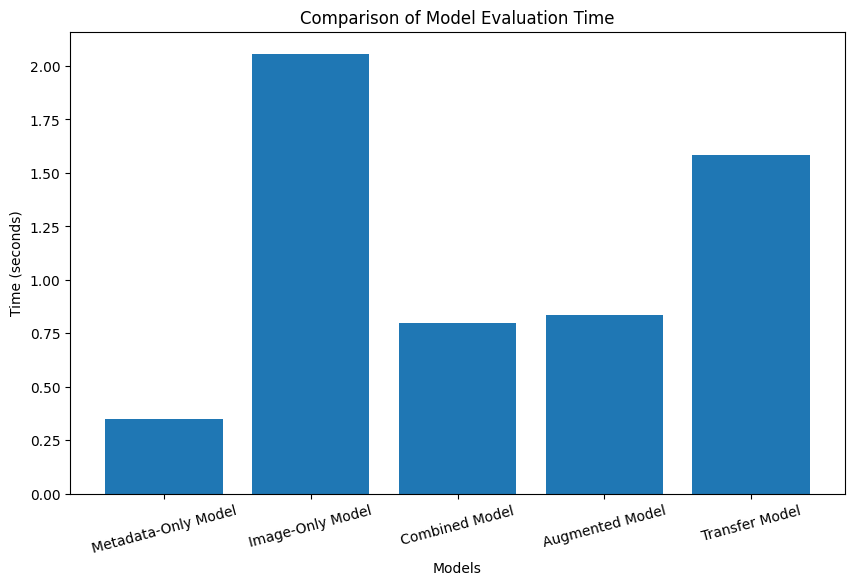

In [34]:
import matplotlib.pyplot as plt

# Plot individual metrics for each model
for index, row in results_df.iterrows():
    model_name = row["Model"]
    metrics = ["Accuracy", "Recall", "F1 Score", "AUC"]
    values = [row[metric] for metric in metrics]

    plt.figure(figsize=(8, 6))
    plt.bar(metrics, values)
    plt.title(f"{model_name} - Performance Metrics")
    plt.ylabel("Score")
    plt.ylim(0, 1)
    plt.show()

# Compare Accuracy
plt.figure(figsize=(10, 6))
plt.bar(results_df["Model"], results_df["Accuracy"])
plt.title("Comparison of Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Models")
plt.xticks(rotation=15)
plt.ylim(0, 1)
plt.show()

# Compare Evaluation Time
plt.figure(figsize=(10, 6))
plt.bar(results_df["Model"], results_df["Evaluation Time (s)"])
plt.title("Comparison of Model Evaluation Time")
plt.ylabel("Time (seconds)")
plt.xlabel("Models")
plt.xticks(rotation=15)
plt.show()
